# 09 - Modelling Round 2
____

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report

from sklearn.model_selection import StratifiedGroupKFold

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

np.random.seed(42)


In [12]:
train = pd.read_csv('feat_sel_2_training_data.csv')
test = pd.read_csv('feat_sel_2_testing_data.csv')

In [13]:
speed_lims = train.speed_limit.value_counts().sort_index().index
age_bands = ['0 - 5', '6 - 10', '11 - 15', '16 - 20', '21 - 25', '26 - 35', '36 - 45', '46 - 55', '56 - 65', '66 - 75', 'Over 75']

for data in [train, test]:
  data['speed_limit'] = pd.Categorical(values=data['speed_limit'], categories=speed_lims, ordered=True)
  data['age_band_of_casualty'] = pd.Categorical(data['age_band_of_casualty'], ordered=True, categories=age_bands)


In [14]:
boolean_feats = [col for col in train.columns if train[col].value_counts().shape[0] == 2]

for dataset in [train, test]:
  for col in boolean_feats:
    dataset[col].replace({dataset[col].value_counts().index[0]: 0, dataset[col].value_counts().index[1]: 1}, inplace=True)

numeric_feats = list(set(train.select_dtypes(include=np.number).columns) - set(boolean_feats))
numeric_feats = [feat for feat in numeric_feats if feat not in ['accident_index']]
ordinal_feats = list(train.select_dtypes(include='category').columns)
nominal_feats = list(train.select_dtypes(exclude=[np.number, bool, 'category']).columns)

### Encoding

Let's target encode all of our columns to see if we can boost our predictive power a bit.

In [15]:
for dataset in [train, test]:
  for col in (ordinal_feats + nominal_feats):
    dataset[col] = dataset.groupby(col)['casualty_severity'].transform('mean')

C:\Users\Elena\AppData\Local\Temp\ipykernel_25136\2276516176.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[col] = dataset.groupby(col)['casualty_severity'].transform('mean')
C:\Users\Elena\AppData\Local\Temp\ipykernel_25136\2276516176.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[col] = dataset.groupby(col)['casualty_severity'].transform('mean')


Let's have a look at the Pearson correlation between our variables and the casualty_severity.

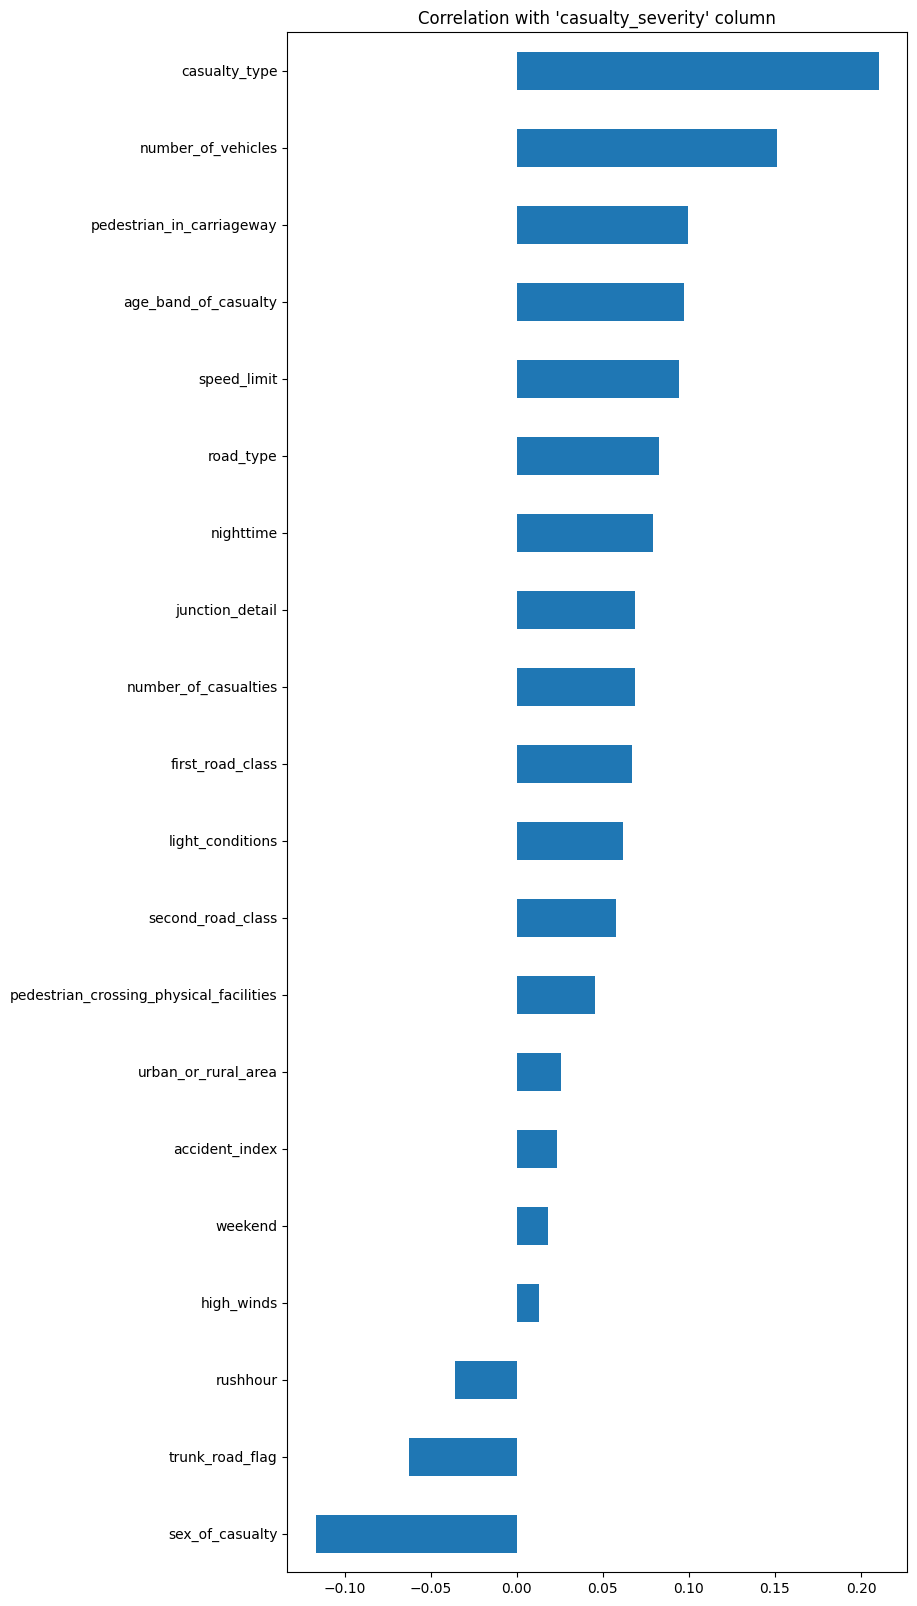

In [16]:
X = train.drop(columns='casualty_severity', axis=1).select_dtypes(include=[np.number, bool])
plt.figure(figsize=(8, 20))
X.corrwith(train['casualty_severity']).sort_values().plot(kind='barh', 
                               title="Correlation with 'casualty_severity' column")
plt.show()

___
# Modelling part 2

In [17]:
groups = train['accident_index'].copy().tolist()

y_train = train['casualty_severity']
X_train = train.drop('casualty_severity', axis=1)

y_test = test['casualty_severity']
X_test = test.drop('casualty_severity', axis=1)

In [19]:
def evaluate_model(model_class, X_train=X_train, y_train=y_train):
    kf = StratifiedGroupKFold(n_splits=5, shuffle=True)
    # Stratified K fold cross validation and predict on training data
    accuracy_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=kf, scoring='accuracy', groups=groups) * 100
    precision_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=kf, scoring='precision', groups=groups) * 100
    recall_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=kf, scoring='recall', groups=groups) * 100
    f1_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=kf, scoring='f1', groups=groups) * 100
    

    metrics_dict = {
        'Model Type': model_class,
        'CV_mean_accuracy': np.round(accuracy_scores.mean(), 1), 
        'CV_mean_precision':np.round(precision_scores.mean(), 1), 
        'CV_mean_recall': np.round(recall_scores.mean(), 1), 
        'CV_mean_F1': np.round(f1_scores.mean(), 1)
        
       
    }   

    return metrics_dict

In [21]:
models = {'KNN': KNeighborsClassifier(), 'Random Forest': RandomForestClassifier(), 'XGBoost': XGBClassifier()}  
model_metric_dict = {}

for key, values in models.items():
  pred = values.fit(X_train, y_train).predict(X_train)
  print(f"\nClassification Report ({key}):")
  print(classification_report(y_train, pred))


Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      8156
           1       0.28      0.22      0.25      3181

    accuracy                           0.62     11337
   macro avg       0.50      0.50      0.50     11337
weighted avg       0.60      0.62      0.61     11337


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8156
           1       0.99      0.98      0.99      3181

    accuracy                           0.99     11337
   macro avg       0.99      0.99      0.99     11337
weighted avg       0.99      0.99      0.99     11337


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.88      0.98      0.92      8156
           1       0.92      0.64      0.76      3181

    accuracy                           0.88     11337
   macro avg       0.90 

In [22]:
for key, values in models.items():
  metrics_dict = evaluate_model(values)
  model_metric_dict.update({key: metrics_dict})

results = pd.DataFrame.from_dict(model_metric_dict).T.round(2)
results.sort_values(by='CV_mean_F1', ascending=False)

,Model Type,CV_mean_accuracy,CV_mean_precision,CV_mean_recall,CV_mean_F1
XGBoost,"XGBClassifier(base_score=None, booster=None, c...",69.2,43.0,26.0,31.5
Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",70.1,44.1,19.6,26.9
KNN,KNeighborsClassifier(),61.5,28.7,21.2,24.0


___

Okay so things to think about here. Obviously, our cross-validated F1 values have dropped a bit for some models. I think this is actually a good thing. The timestamp data was probably leaking across the cross-val datasets and artificially boosting the model's accuracy by learning the worst collisions. Now that we've gotten rid of that data we don't have the data leakage.

The RF model is giving a similar cross-validated F1 score, but I suspect this is still massively overfitting, so we should remain a little cautious about which model we want to focus on.

I think at this point, it's time that we start investigating over / under sampling techniques, then we can "trim the fat" of the excess features that we have. We want to resample before doing any feature elimination to make sure that we don't lose any valuable information about our minority class.

In [146]:
train.to_csv('encoded_train.csv', index=False)
test.to_csv('encoded_test.csv', index=False)


<Axes: >

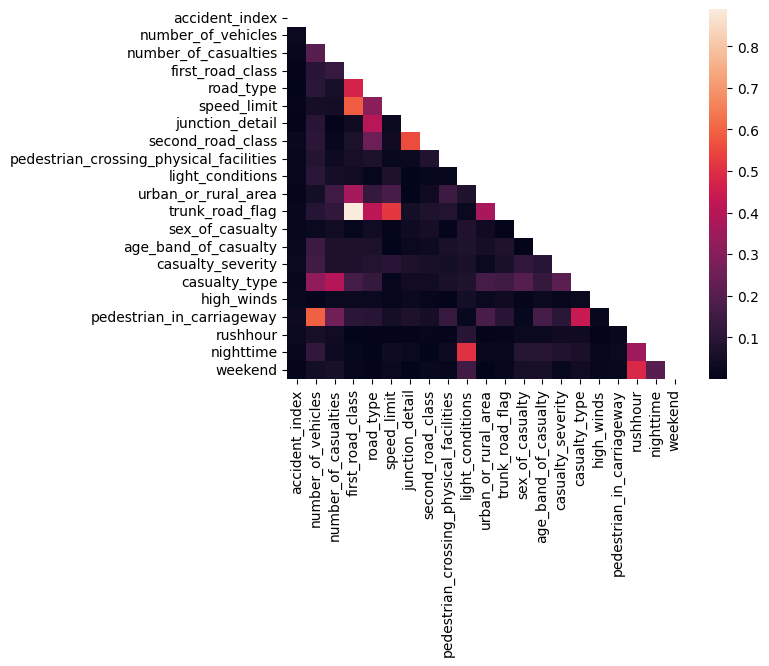

In [23]:
import seaborn as sns 
corr = abs(train.corr())
mask=np.triu(np.ones_like(corr, dtype=bool))
# corr = abs(train.corr())
sns.heatmap(corr, mask=mask)